In [10]:
RUN_TRAIN = True # bfloat16 or float32 recommended
RUN_VALID = False
RUN_TEST  = False
USE_DEVICE = 'GPU' #'CPU'  # 'GPU'

import torch
# if USE_DEVICE == 'GPU':
#     if not torch.cuda.is_available() or torch.cuda.device_count() < 2:
#         raise RuntimeError("Requires >= 2 GPUs with CUDA enabled.")

try: 
    import monai
except: 
    !pip install --no-deps monai -q

In [11]:
%%writefile _cfg.py

from types import SimpleNamespace
import torch
import glob

cfg= SimpleNamespace()
cfg.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg.local_rank = 0
cfg.seed = 123
cfg.subsample = 100 #None
data_paths = sorted(glob.glob("./datasetfiles/FlatVel_A/data/*.npy"))
label_paths = sorted(glob.glob("./datasetfiles/FlatVel_A/model/*.npy"))
cfg.file_pairs = list(zip(sorted(glob.glob("./datasetfiles/FlatVel_A/data/*.npy")), sorted(glob.glob("./datasetfiles/FlatVel_A/model/*.npy"))))
# cfg.file_pairs = list(zip(data_paths, label_paths))

cfg.backbone = "convnext_small.fb_in22k_ft_in1k"
cfg.ema = True
cfg.ema_decay = 0.99

cfg.epochs = 4
cfg.batch_size = 8  # 16
cfg.batch_size_val = 8 # 16

cfg.early_stopping = {"patience": 3, "streak": 0}
cfg.logging_steps = 10



Overwriting _cfg.py


In [ ]:
# %%writefile _dataset.py

import os, sys
import glob

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch


class CustomDataset(torch.utils.data.Dataset):
    def __init__(
        self, 
        cfg,
        file_pairs,  #list of (data_path, label_path) tuples for this specific split
        mode = "train", 
    ):
        self.cfg = cfg
        self.mode = mode
        self.file_pairs = file_pairs
        
        self.data, self.labels = self._load_data_arrays()

        self.samples_per_file = 500  # assuming each file has 500 time steps
        total_samples_available = len(self.data) * self.samples_per_file

        # Subsample logic
        subsample = getattr(self.cfg, "subsample", None)
        self.total_samples = min(subsample, total_samples_available) if subsample else total_samples_available

        
        # Build list of (file_idx, time_step_idx) pairs
        self.index_map = []
        for file_idx in range(len(self.data)):
            for time_step_idx in range(self.samples_per_file):
                self.index_map.append((file_idx, time_step_idx))
                if len(self.index_map) >= self.total_samples:
                    break
            if len(self.index_map) >= self.total_samples:
                break

    def _load_data_arrays(self, ):
               
        data_arrays = []
        label_arrays = []
        mmap_mode = "r"

        for data_fpath, label_fpath in tqdm(
                        self.file_pairs, desc=f"Loading {self.mode} data (mmap)",
                        disable=self.cfg.local_rank != 0):
            try:
                # Load the numpy arrays using memory mapping
                arr = np.load(data_fpath, mmap_mode=mmap_mode)
                lbl = np.load(label_fpath, mmap_mode=mmap_mode)
                print(f"Loaded {data_fpath}: {arr.shape}, {lbl.shape}")
                data_arrays.append(arr)
                label_arrays.append(lbl)
            except FileNotFoundError:
                print(f"Error: File not found - {data_fpath} r {label_fpath}", file=sys.stderr)
            except Exception as e:
                print(f"Error loading file pari: {data_fpath}, {label_fpath}", file=sys.stderr)
                print(f"Error: {e}", file=sys.stderr)
                continue

            if self.cfg.local_rank == 0:
                print(f"Finished loading {len(data_arrays)} file pairs for {self.mode} mode.")

        return data_arrays, label_arrays

    def __getitem__(self, idx):
        # file_idx= idx // 500
        # time_step_idx= idx % 500
        # self.idx = idx

        file_idx, time_step_idx = self.index_map[idx]
        
        x_full = self.data[file_idx]
        y_full = self.labels[file_idx]

        # --- Augmentations ---
        # Apply augmentations to the full 3D blocks *before* slicing out the time step.
        # Make copies after slicing and augmentation to ensure memory safety.
        x_augmented = x_full
        y_augmented = y_full

        # Augs 
        if self.mode == "train":
            
            # Temporal flip
            if np.random.random() < 0.5:
                x_augmented = x_full[::-1, :, ::-1] # Time flip (dim 0), Spatial flip (dim 2)
                y_augmented = y_full[..., ::-1]  # Spatial flip (dim 2) only

        # --- Slicing and Copying ---
        # Get the specific time step from the (potentially augmented) full array
        # This reslts in a 2D array (Dim1, Dim2)
        x_sample = x_augmented[time_step_idx, ...]
        y_sample = y_augmented[time_step_idx, ...]

        # make copies to return independent arrays/tensors.
        # This is important especially with mmap and multiprocessing DataLoaders.
        x_sample = x_sample.copy()
        y_sample = y_sample.copy()

        x_tensor = torch.from_numpy(x_sample).float()
        y_tensor = torch.from_numpy(y_sample).float()
        
        return x_tensor, y_tensor

    def __len__(self, ):
        return self.total_samples

In [13]:
# %%writefile _model.py

from copy import deepcopy
from types import MethodType

import torch
import torch.nn as nn
import torch.nn.functional as F

import timm
from timm.models.convnext import ConvNeXtBlock

from monai.networks.blocks import UpSample, SubpixelUpsample

####################
## EMA + Ensemble ##
####################

class ModelEMA(nn.Module):
    def __init__(self, model, decay=0.99, device=None):
        super().__init__()
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device
        if self.device is not None:
            self.module.to(device=device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(), model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def set(self, model):
        self._update(model, update_fn=lambda e, m: m)


class EnsembleModel(nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = nn.ModuleList(models).eval()

    def forward(self, x):
        output = None
        
        for m in self.models:
            logits= m(x)
            
            if output is None:
                output = logits
            else:
                output += logits
                
        output /= len(self.models)
        return output
        

#############
## Decoder ##
#############

class ConvBnAct2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding: int = 0,
        stride: int = 1,
        norm_layer: nn.Module = nn.Identity,
        act_layer: nn.Module = nn.ReLU,
    ):
        super().__init__()

        self.conv= nn.Conv2d(
            in_channels, 
            out_channels,
            kernel_size,
            stride=stride, 
            padding=padding, 
            bias=False,
        )
        self.norm = norm_layer(out_channels) if norm_layer != nn.Identity else nn.Identity()
        self.act= act_layer(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.act(x)
        return x


class SCSEModule2d(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.Tanh(),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(
            nn.Conv2d(in_channels, 1, 1), 
            nn.Sigmoid(),
            )

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)

class Attention2d(nn.Module):
    def __init__(self, name, **params):
        super().__init__()
        if name is None:
            self.attention = nn.Identity(**params)
        elif name == "scse":
            self.attention = SCSEModule2d(**params)
        else:
            raise ValueError("Attention {} is not implemented".format(name))

    def forward(self, x):
        return self.attention(x)

class DecoderBlock2d(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        norm_layer: nn.Module = nn.Identity,
        attention_type: str = None,
        intermediate_conv: bool = False,
        upsample_mode: str = "deconv",
        scale_factor: int = 2,
    ):
        super().__init__()

        # Upsample block
        if upsample_mode == "pixelshuffle":
            self.upsample= SubpixelUpsample(
                spatial_dims= 2,
                in_channels= in_channels,
                scale_factor= scale_factor,
            )
        else:
            self.upsample = UpSample(
                spatial_dims= 2,
                in_channels= in_channels,
                out_channels= in_channels,
                scale_factor= scale_factor,
                mode= upsample_mode,
            )

        if intermediate_conv:
            k= 3
            c= skip_channels if skip_channels != 0 else in_channels
            self.intermediate_conv = nn.Sequential(
                ConvBnAct2d(c, c, k, k//2),
                ConvBnAct2d(c, c, k, k//2),
                )
        else:
            self.intermediate_conv= None

        self.attention1 = Attention2d(
            name= attention_type, 
            in_channels= in_channels + skip_channels,
            )

        self.conv1 = ConvBnAct2d(
            in_channels + skip_channels,
            out_channels,
            kernel_size= 3,
            padding= 1,
            norm_layer= norm_layer,
        )

        self.conv2 = ConvBnAct2d(
            out_channels,
            out_channels,
            kernel_size= 3,
            padding= 1,
            norm_layer= norm_layer,
        )
        self.attention2 = Attention2d(
            name= attention_type, 
            in_channels= out_channels,
            )

    def forward(self, x, skip=None):
        x = self.upsample(x)

        if self.intermediate_conv is not None:
            if skip is not None:
                skip = self.intermediate_conv(skip)
            else:
                x = self.intermediate_conv(x)

        if skip is not None:
            # print(x.shape, skip.shape)
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class UnetDecoder2d(nn.Module):
    """
    Unet decoder.
    Source: https://arxiv.org/abs/1505.04597
    """
    def __init__(
        self,
        encoder_channels: tuple[int],
        skip_channels: tuple[int] = None,
        decoder_channels: tuple = (256, 128, 64, 32),
        scale_factors: tuple = (2,2,2,2),
        norm_layer: nn.Module = nn.Identity,
        attention_type: str = None,
        intermediate_conv: bool = False,
        upsample_mode: str = "deconv",
    ):
        super().__init__()
        
        if len(encoder_channels) == 4:
            decoder_channels= decoder_channels[1:]
        self.decoder_channels= decoder_channels
        
        if skip_channels is None:
            skip_channels= list(encoder_channels[1:]) + [0]

        # Build decoder blocks
        in_channels= [encoder_channels[0]] + list(decoder_channels[:-1])
        self.blocks = nn.ModuleList()

        for i, (ic, sc, dc) in enumerate(zip(in_channels, skip_channels, decoder_channels)):
            # print(i, ic, sc, dc)
            self.blocks.append(
                DecoderBlock2d(
                    ic, sc, dc, 
                    norm_layer= norm_layer,
                    attention_type= attention_type,
                    intermediate_conv= intermediate_conv,
                    upsample_mode= upsample_mode,
                    scale_factor= scale_factors[i],
                    )
            )

    def forward(self, feats: list[torch.Tensor]):
        res= [feats[0]]
        feats= feats[1:]

        # Decoder blocks
        for i, b in enumerate(self.blocks):
            skip= feats[i] if i < len(feats) else None
            res.append(
                b(res[-1], skip=skip),
                )
            
        return res

class SegmentationHead2d(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        scale_factor: tuple[int] = (2,2),
        kernel_size: int = 3,
        mode: str = "nontrainable",
    ):
        super().__init__()
        self.conv= nn.Conv2d(
            in_channels, out_channels, kernel_size= kernel_size,
            padding= kernel_size//2
        )
        self.upsample = UpSample(
            spatial_dims= 2,
            in_channels= out_channels,
            out_channels= out_channels,
            scale_factor= scale_factor,
            mode= mode,
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.upsample(x)
        return x
        

#############
## Encoder ##
#############

def _convnext_block_forward(self, x):
    shortcut = x
    x = self.conv_dw(x)

    if self.use_conv_mlp:
        x = self.norm(x)
        x = self.mlp(x)
    else:
        x = self.norm(x)
        x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
        x = self.mlp(x)
        x = x.permute(0, 3, 1, 2)
        x = x.contiguous()

    if self.gamma is not None:
        x = x * self.gamma.reshape(1, -1, 1, 1)

    x = self.drop_path(x) + self.shortcut(shortcut)
    return x


class Net(nn.Module):
    def __init__(
        self,
        backbone: str,
        pretrained: bool = True,
    ):
        super().__init__()
        
        # Encoder
        self.backbone= timm.create_model(
            backbone,
            in_chans= 5,
            pretrained= pretrained,
            features_only= True,
            drop_path_rate=0.0,
            )
        ecs= [_["num_chs"] for _ in self.backbone.feature_info][::-1]

        # Decoder
        self.decoder= UnetDecoder2d(
            encoder_channels= ecs,
        )

        self.seg_head= SegmentationHead2d(
            in_channels= self.decoder.decoder_channels[-1],
            out_channels= 1,
            scale_factor= 1,
        )
        
        self._update_stem(backbone)
        
        self.replace_activations(self.backbone, log=True)
        self.replace_norms(self.backbone, log=True)
        self.replace_forwards(self.backbone, log=True)

    def _update_stem(self, backbone):
        if backbone.startswith("convnext"):

            # Update stride
            self.backbone.stem_0.stride = (4, 1)
            self.backbone.stem_0.padding = (0, 2)

            # Duplicate stem layer (to downsample height)
            with torch.no_grad():
                w = self.backbone.stem_0.weight
                new_conv= nn.Conv2d(w.shape[0], w.shape[0], kernel_size=(4, 4), stride=(4, 1), padding=(0, 1))
                new_conv.weight.copy_(w.repeat(1, (128//w.shape[1])+1, 1, 1)[:, :new_conv.weight.shape[1], :, :])
                new_conv.bias.copy_(self.backbone.stem_0.bias)

            self.backbone.stem_0= nn.Sequential(
                nn.ReflectionPad2d((1,1,80,80)),
                self.backbone.stem_0,
                new_conv,
            )

        else:
            raise ValueError("Custom striding not implemented.")
        pass

    def replace_activations(self, module, log=False):
        if log:
            print(f"Replacing all activations with GELU...")
        
        # Apply activations
        for name, child in module.named_children():
            if isinstance(child, (
                nn.ReLU, nn.LeakyReLU, nn.Mish, nn.Sigmoid, 
                nn.Tanh, nn.Softmax, nn.Hardtanh, nn.ELU, 
                nn.SELU, nn.PReLU, nn.CELU, nn.GELU, nn.SiLU,
            )):
                setattr(module, name, nn.GELU())
            else:
                self.replace_activations(child)

    def replace_norms(self, mod, log=False):
        if log:
            print(f"Replacing all norms with InstanceNorm...")
            
        for name, c in mod.named_children():

            # Get feature size
            n_feats= None
            if isinstance(c, (nn.BatchNorm2d, nn.InstanceNorm2d)):
                n_feats= c.num_features
            elif isinstance(c, (nn.GroupNorm,)):
                n_feats= c.num_channels
            elif isinstance(c, (nn.LayerNorm,)):
                n_feats= c.normalized_shape[0]

            if n_feats is not None:
                new = nn.InstanceNorm2d(
                    n_feats,
                    affine=True,
                    )
                setattr(mod, name, new)
            else:
                self.replace_norms(c)

    def replace_forwards(self, mod, log=False):
        if log:
            print(f"Replacing forward functions...")
            
        for name, c in mod.named_children():
            if isinstance(c, ConvNeXtBlock):
                c.forward = MethodType(_convnext_block_forward, c)
            else:
                self.replace_forwards(c)

        
    def proc_flip(self, x_in):
        x_in= torch.flip(x_in, dims=[-3, -1])
        x= self.backbone(x_in)
        x= x[::-1]

        # Decoder
        x= self.decoder(x)
        x_seg= self.seg_head(x[-1])
        x_seg= x_seg[..., 1:-1, 1:-1]
        x_seg= torch.flip(x_seg, dims=[-1])
        x_seg= x_seg * 1500 + 3000
        return x_seg

    def forward(self, batch):
        x= batch

        # Encoder
        x_in = x
        x= self.backbone(x)
        # print([_.shape for _ in x])
        x= x[::-1]

        # Decoder
        x= self.decoder(x)
        # print([_.shape for _ in x])
        x_seg= self.seg_head(x[-1])
        x_seg= x_seg[..., 1:-1, 1:-1]
        x_seg= x_seg * 1500 + 3000
    
        if self.training:
            return x_seg
        else:
            p1 = self.proc_flip(x_in)
            x_seg = torch.mean(torch.stack([x_seg, p1]), dim=0)
            return x_seg

In [14]:
# %%writefile _utils.py

import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# hook activations and gradients
activations = {}
gradients = {}

def save_activation(name):
    def hook(module, input, output):
        activations[name] = output.detach()
    return hook

def save_gradient(name):
    def hook(module, grad_input, grad_output):
        # grad_output is a tuple (gradients w.r.t. outputs)
        gradients[name] = grad_output[0].detach()
    return hook

In [15]:
# training code for CPU

import random
import os
import time, glob
import numpy as np
import torch
# Remove or comment out if you don't have it (but typically comes with pytorch)
# import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset # Use standard DataLoader/Dataset
# from torch.utils.data.distributed import DistributedSampler # Removed
# from torch.cuda.amp import autocast, GradScaler # Removed
from tqdm import tqdm
from _cfg import cfg

cfg.local_rank = 0
cfg.world_size = 1
# cfg.device = 'cpu' # Ensure device is set to CPU

def set_seed(seed=cfg.seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # Removed torch.cuda.manual_seed, torch.backends.cudnn settings

data_paths = sorted(glob.glob("./datasetfiles/FlatVel_A/data/*.npy"))
label_paths = sorted(glob.glob("./datasetfiles/FlatVel_A/model/*.npy"))
file_pairs = list(zip(data_paths, label_paths))



# Ensure device is set to 'cpu' in cfg for clarity in this modified version
# cfg.device = 'cpu'

# ========== Datasets / Dataloaders ==========
if cfg.local_rank == 0:
    print("="*25)
    print("Loading data..")

print(f"file_pairs: {cfg.file_pairs[:2]}")
print(f"Type of first element: {type(cfg.file_pairs[0])}")
train_ds = CustomDataset(cfg=cfg, file_pairs=file_pairs, mode="train")
# Replaced DistributedSampler with standard DataLoader and shuffle
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size= cfg.batch_size,
    num_workers= 0, #4,
    shuffle=True, # Add shuffle for training
)

valid_ds = CustomDataset(cfg=cfg, file_pairs=file_pairs, mode="valid")
# Replaced DistributedSampler with standard DataLoader
valid_dl = torch.utils.data.DataLoader(
    valid_ds,
    batch_size= cfg.batch_size_val,
    num_workers= 0, #4,
    shuffle=False, # No shuffle for validation
)


x, y = train_ds[0]
print("Sample shape:", x.shape, y.shape)
# ========== Model / Optim ==========
model = Net(backbone=cfg.backbone).to(cfg.device)
# Removed .to(cfg.local_rank) - models are on CPU by default

#-----
""" 
HOOK activation and gradient 
"""
layers_to_track = [
    "model.backbone.stem_1",               # Right after convolutional stem
    "model.backbone.stages_0.blocks.2",    # Last block of the first ConvNeXt stage.
    "model.backbone.stages_1.blocks.1",    # Last block of the second stage
    "model.backbone.stages_2.blocks.2",    # Last block of the third satate
    "model.backbone.stages_3.blocks.1",    # Last block of the fourth stage
    "model.decoder.blocks.0", # Example: first decoder block
    "model.decoder.blocks.3", # Example: last decoder block
    "model.seg_head.conv",    # Before final upsampling
]
"""Avoid [.2] is condiered floating point Should be treated as Index"""
def get_module_by_name(model, name):
    parts = name.split(".")
    module = model
    for part in parts:
        if part.isdigit():  # Handle list-like indices
            module = module[int(part)]
        else:
            module = getattr(module, part)
    return module

# hooks = []
# for i, layer_name in enumerate(layers_to_track):
#     layer = get_module_by_name(model, layer_name.replace("model.", ""))
#     hooks.append(layer.register_forward_hook(save_activation(f"layer_{i}")))
#     hooks.append(layer.register_full_backward_hook(save_gradient(f"layer_{i}")))

hook_handles = []

for i, layer_name in enumerate(layers_to_track):
    try:
        layer = get_module_by_name(model, layer_name)
        # Register the hooks using the factory functions
        handle_act = layer.register_forward_hook(save_activation(layer_name))
        handle_grad = layer.register_full_backward_hook(save_gradient(layer_name))
        hook_handles.append(handle_act)
        hook_handles.append(handle_grad)
        print(f"Registered hooks for: {layer_name}")
    except AttributeError as e:
        print(f"Could not find module {layer_name}: {e}")
        # Handle cases where a layer name might be incorrect for a specific backbone
# For each selected layer, plot:
# Mean activation per channel
# Standard deviation per channel
# Optionally: min/max or histogram of activations
# This will help detect:
# Dead neurons (very low variance or flat mean)
# Saturation (high means near nonlinearity limits, e.g. ReLU cutoffs)
# Vanishing/exploding signals
#------


if cfg.ema:
    if cfg.local_rank == 0:
        print("Initializing EMA model..")
    # Set device explicitly to 'cpu' for EMA
    ema_model = ModelEMA(
        model,
        decay=cfg.ema_decay,
        device=cfg.device,
    )
else:
    ema_model = None

# Removed DistributedDataParallel wrap - use the base model directly

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Removed GradScaler - not needed for CPU or non-mixed precision


parameters_conv = []
for m in model.modules():
    if isinstance(m, nn.Conv2d) and m.weight.requires_grad:
        p = m.weight
        if p.ndim == 4:
            # print(f"p as param with shape {p.shape} from module {m}")
            parameters_conv.append(p)
ud = []
eps = 1e-8



# ========== Training ==========
if cfg.local_rank == 0:
    print("="*25)
    # Adjusted print message
    print(f"Running on {cfg.device} (single process).")
    print("="*25)

best_loss= 1_000_000
val_loss= 1_000_000 # Initialize val_loss for logging on epoch 0

for epoch in range(0, cfg.epochs+1):
    if epoch != 0: # Skip epoch 0 training loop
        tstart= time.time()
        # Removed sampler.set_epoch - not needed for standard DataLoader

        # Train loop
        model.train()
        total_loss = []
        # tqdm for train loop only on rank 0
        train_loop = tqdm(train_dl, disable=cfg.local_rank != 0, desc=f"Epoch {epoch} Training")
        for i, (x, y) in enumerate(train_loop):
            # Removed .to(cfg.local_rank) - data is already on CPU
            # Removed autocast context
            x = x.to(cfg.device)
            y = y.to(cfg.device)

            logits = model(x)

            loss = criterion(logits, y)

            # Replaced scaler steps with standard backprop and optimizer step
            loss.backward()
            # Removed scaler.unscale_

            ### Trach UD

            lr = optimizer.param_groups[0]['lr']
            with torch.no_grad():
                ud.append([
                        (lr * (p.grad.std() + eps) / (p.data.std() + eps)).log10().item()
                        if p.grad is not None else float('-inf')
                        for p in parameters_conv
                ])


            # for idx, p in enumerate(parameters_conv):
            #     if p.grad is None:
            #         print(f"Parameter {idx} ({p.shape}) has no grad after backward")
            ### Trach UD  ------------- before optimizer

            optimizer.step()
            # Removed scaler.update
            optimizer.zero_grad()

            total_loss.append(loss.item())

            if ema_model is not None:
                ema_model.update(model)

            # Logging within the loop (simplified for single process)
            if cfg.local_rank == 0 and (len(total_loss) >= cfg.logging_steps or i == len(train_dl)-1 or i == 0):
                current_train_loss_avg = np.mean(total_loss[-cfg.logging_steps:]) # Avg of last logging steps
                if i == 0: current_train_loss_avg = total_loss[0] # Handle first step log
                train_loop.set_postfix(train_mae=f"{current_train_loss_avg:.4f}", val_mae=f"{val_loss:.4f}")
                # Original logging format (can keep if preferred, but tqdm is better)
                # if (len(total_loss) % cfg.logging_steps == 0 or i == len(train_dl)-1):
                #    train_loss_avg = np.mean(total_loss)
                #    print("Epoch {}:     Train MAE: {:.2f}     Val MAE: {:.2f}     Time: {}     Step: {}/{}".format(
                #        epoch,
                #        train_loss_avg,
                #        val_loss,
                #        format_time(time.time() - tstart),
                #        i+1,
                #        len(train_dl), # Fix len(train_dl)+1 -> len(train_dl)
                #    ))
                
            

        # Log average train loss after epoch
        if cfg.local_rank == 0:
                train_loss_avg_epoch = np.mean(total_loss)
                print(f"\nEpoch {epoch} Training finished. Avg Train MAE: {train_loss_avg_epoch:.4f}")


    # ========== Valid ==========
    model.eval()
    val_logits = []
    val_targets = []
    # tqdm for validation loop on rank 0
    valid_loop = tqdm(valid_dl, disable=cfg.local_rank != 0, desc=f"Epoch {epoch} Validation")
    with torch.no_grad():
        for x, y in valid_loop:
            # Removed .to(cfg.local_rank) - data is already on CPU
            x = x.to(cfg.device)
            y = y.to(cfg.device)
            
            # Removed autocast context
            if ema_model is not None:
                # Access the underlying model from EMA wrapper
                # out = ema_model.ema_model(x) # Or ema_model.model(x) depending on EMA implementation
                out = ema_model.module(x) # Or ema_model.model(x) depending on EMA implementation
            else:
                out = model(x)

            val_logits.append(out.cpu())
            val_targets.append(y.cpu())

        val_logits= torch.cat(val_logits, dim=0)
        val_targets= torch.cat(val_targets, dim=0)

        # Calculate loss directly (no all_reduce needed)
        val_loss = criterion(val_logits, val_targets).item()

    # Removed Gather loss (all_reduce) - loss is already the final val_loss

    # ========== Weights / Early stopping ==========
    # Removed stop_train tensor and broadcast - handled directly in single process
    if cfg.local_rank == 0: # This block runs because local_rank is 0
        es= cfg.early_stopping # Ensure es is a local variable
        if val_loss < best_loss:
            print(f"\nNew best: {best_loss:.4f} -> {val_loss:.4f}") # Improved formatting
            print("Saved weights..")
            best_loss = val_loss
            if ema_model is not None:
                # Save the state dict of the EMA model's actual weights
                # Assuming ModelEMA stores the EMA model internally, e.g., as .ema_model
                # Adjust this line based on your ModelEMA implementation
                torch.save(ema_model.module.state_dict(), f'best_model_{cfg.seed}.pt')
            else:
                torch.save(model.state_dict(), f'best_model_{cfg.seed}.pt')

            es["streak"] = 0
        else:
            es["streak"] += 1
            print(f"\nValidation loss did not improve. Streak: {es['streak']}/{es['patience']}") # Added log
            if es["streak"] > es["patience"]:
                print("Ending training (early_stopping).")
                # Direct return for early stopping
                # return # Exit the main function

    # Added a short delay to allow print statements to flush if needed (less critical for CPU)
    # time.sleep(1) # Optional



Loading data..
file_pairs: [('./datasetfiles/FlatVel_A/data\\data1.npy', './datasetfiles/FlatVel_A/model\\model1.npy'), ('./datasetfiles/FlatVel_A/data\\data2.npy', './datasetfiles/FlatVel_A/model\\model2.npy')]
Type of first element: <class 'tuple'>


Loading train data (mmap): 100%|██████████| 2/2 [00:00<00:00, 614.24it/s]


Loaded ./datasetfiles/FlatVel_A/data\data1.npy: (500, 5, 1000, 70), (500, 1, 70, 70)
Finished loading 1 file pairs for train mode.
Loaded ./datasetfiles/FlatVel_A/data\data2.npy: (500, 5, 1000, 70), (500, 1, 70, 70)
Finished loading 2 file pairs for train mode.


Loading valid data (mmap): 100%|██████████| 2/2 [00:00<00:00, 730.33it/s]

Loaded ./datasetfiles/FlatVel_A/data\data1.npy: (500, 5, 1000, 70), (500, 1, 70, 70)
Finished loading 1 file pairs for valid mode.
Loaded ./datasetfiles/FlatVel_A/data\data2.npy: (500, 5, 1000, 70), (500, 1, 70, 70)
Finished loading 2 file pairs for valid mode.
Sample shape: torch.Size([5, 1000, 70]) torch.Size([1, 70, 70])


Replacing all activations with GELU...
Replacing all norms with InstanceNorm...
Replacing forward functions...
Could not find module model.backbone.stem_1: 'Net' object has no attribute 'model'
Could not find module model.backbone.stages_0.blocks.2: 'Net' object has no attribute 'model'
Could not find module model.backbone.stages_1.blocks.1: 'Net' object has no attribute 'model'
Could not find module model.backbone.stages_2.blocks.2: 'Net' object has no attribute 'model'
Could not find module model.backbone.stages_3.blocks.1: 'Net' object has no attribute 'model'
Could not find module model.decoder.blocks.0: 'Net' object has no attribute 'model'
Could not find module model.decoder.blocks.3: 'Net' object has no attribute 'model'
Could not find module model.seg_head.conv: 'Net' object has no attribute 'model'
Initializing EMA model..
Running on cuda (single process).


Epoch 0 Validation: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]



New best: 1000000.0000 -> 828.7915
Saved weights..


Epoch 1 Training: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s, train_mae=657.7573, val_mae=828.7915]



Epoch 1 Training finished. Avg Train MAE: 660.8648


Epoch 1 Validation: 100%|██████████| 13/13 [00:03<00:00,  3.53it/s]



New best: 828.7915 -> 736.6650
Saved weights..


Epoch 2 Training: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s, train_mae=504.5261, val_mae=736.6650]



Epoch 2 Training finished. Avg Train MAE: 520.2113


Epoch 2 Validation: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]



New best: 736.6650 -> 680.4133
Saved weights..


Epoch 3 Training: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s, train_mae=458.3407, val_mae=680.4133]



Epoch 3 Training finished. Avg Train MAE: 472.8246


Epoch 3 Validation: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]



New best: 680.4133 -> 647.1085
Saved weights..


Epoch 4 Training: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s, train_mae=461.2521, val_mae=647.1085]



Epoch 4 Training finished. Avg Train MAE: 481.9312


Epoch 4 Validation: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]



New best: 647.1085 -> 622.6318
Saved weights..


In [ ]:

def plot_monitoring_data(data_dict, title="Model Monitoring: Activations and Gradients"):
    """
    Plots activation and gradient norms collected during training.

    Args:
        data_dict (dict): Dictionary containing monitoring data
                          {'layer_name_metric': [(step, value), ...]}
        title (str): Plot title.
    """
    layers = sorted(list(set([key.rsplit('_', 2)[0] for key in data_dict.keys()])))

    if not layers:
        print("No monitoring data available to plot.")
        return

    n_layers = len(layers)
    fig, axes = plt.subplots(n_layers, 2, figsize=(15, n_layers * 3.5), squeeze=False)
    fig.suptitle(title, fontsize=16)

    for i, layer_name in enumerate(layers):
        # Plot Activation Norm
        act_key = f'{layer_name}_activation_norm'
        if act_key in data_dict and data_dict[act_key]:
            steps, values = zip(*data_dict[act_key])
            axes[i, 0].plot(steps, values, label='Activation Norm')
            axes[i, 0].set_ylabel(f'{layer_name}\nAct Norm')
            axes[i, 0].grid(True, linestyle='--', alpha=0.6)
            axes[i, 0].tick_params(axis='y', labelsize=8)
            axes[i, 0].tick_params(axis='x', labelsize=8)
            if i == n_layers - 1:
                 axes[i, 0].set_xlabel("Training Step")
            else:
                 axes[i, 0].set_xticklabels([]) # Remove x-labels for upper plots

        # Plot Gradient Norm
        grad_key = f'{layer_name}_gradient_norm'
        if grad_key in data_dict and data_dict[grad_key]:
            steps, values = zip(*data_dict[grad_key])
            # Filter out NaNs if any (e.g., for layers without gradients in some steps)
            valid_data = [(s, v) for s, v in zip(steps, values) if not np.isnan(v)]
            if valid_data:
                steps, values = zip(*valid_data)
                axes[i, 1].plot(steps, values, label='Gradient Norm', color='tab:orange')
                axes[i, 1].set_ylabel(f'{layer_name}\nGrad Norm')
                axes[i, 1].grid(True, linestyle='--', alpha=0.6)
                axes[i, 1].tick_params(axis='y', labelsize=8)
                axes[i, 1].tick_params(axis='x', labelsize=8)
                # Add log scale suggestion if values are very spread out
                # if max(values) / (min([v for v in values if v > 1e-9]) + 1e-9) > 100:
                #     axes[i, 1].set_yscale('log')
                #     axes[i, 1].set_ylabel(f'{layer_name}\nGrad Norm (log)')

            if i == n_layers - 1:
                axes[i, 1].set_xlabel("Training Step")
            else:
                axes[i, 1].set_xticklabels([]) # Remove x-labels for upper plots


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

In [ ]:
# print(model.backbone)
for name, module in model.named_modules():
    print(name)

In [35]:
from torchviz import make_dot
input = torch.randn(8, 5, 1000, 70, requires_grad=True).to(cfg.device)
y = model(input)
make_dot(y).render("model_structure", format="png")

d:\dev\mit\env\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.602091 to fit


'model_structure.png'

In [7]:
activations

{'layer_0': tensor([[[[ 9.2010e+00, -6.4183e-01, -9.1564e+00,  ...,  3.7966e+00,
             1.2563e+01,  3.3204e+00],
           [-2.4045e+00,  9.9440e-01,  3.2849e+00,  ..., -3.7680e+00,
            -3.8368e+00, -3.3326e-03],
           [-2.3537e+00,  7.3460e-01,  3.6802e+00,  ..., -8.9999e-01,
            -5.0495e+00, -2.4433e+00],
           ...,
           [ 5.3388e-01,  7.4128e-03,  8.2725e-03,  ...,  6.0068e-03,
             3.9289e-03, -7.2989e-01],
           [ 5.3392e-01,  6.1533e-03,  7.6770e-03,  ...,  6.7235e-03,
             4.4022e-03, -7.2993e-01],
           [ 5.3545e-01,  6.2711e-03,  8.1430e-03,  ...,  6.3848e-03,
             5.2604e-03, -7.2770e-01]],
 
          [[ 5.8709e+00,  4.1899e+00,  4.9660e+00,  ..., -9.1722e+00,
            -1.5638e+01, -8.1679e+00],
           [-1.1005e+00,  1.5852e+00,  7.2726e-01,  ...,  4.1624e+00,
             5.9790e+00, -4.1950e-01],
           [-1.8569e+00, -1.5970e+00, -1.7181e+00,  ...,  2.9036e+00,
             4.6318e+00,  3.

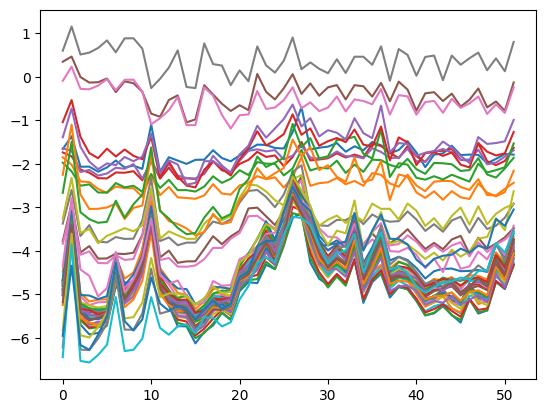

In [7]:
import matplotlib.pyplot as plt
plt.plot(ud);

In [42]:
import matplotlib.pyplot as plt

# Hook function
activation_stats = {}
def get_hook(name):
    def hook(model, input, output):
        # Compute stats over batch and spatial dims
        activation_stats[name] = {
            'mean': output.mean(dim=(0, 2, 3)).detach().cpu().numpy(),
            'std': output.std(dim=(0, 2, 3)).detach().cpu().numpy()
        }
    return hook

layers_to_track = [
    "model.backbone.stem_1",               # Right after convolutional stem
    "model.backbone.stages_0.blocks.2",    # Last block of the first ConvNeXt stage.
    "model.backbone.stages_1.blocks.1",    # Last block of the second stage
    "model.backbone.stages_2.blocks.2",    # Last block of the third satate
    "model.backbone.stages_3.blocks.1",    # Last block of the fourth stage
]
for layer_name in layers_to_track:
    layer = get_module_by_name(model, layer_name.replace("model.", ""))
    layer.register_forward_hook(get_hook(i))
# Register hooks


d:\dev\mit\env\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


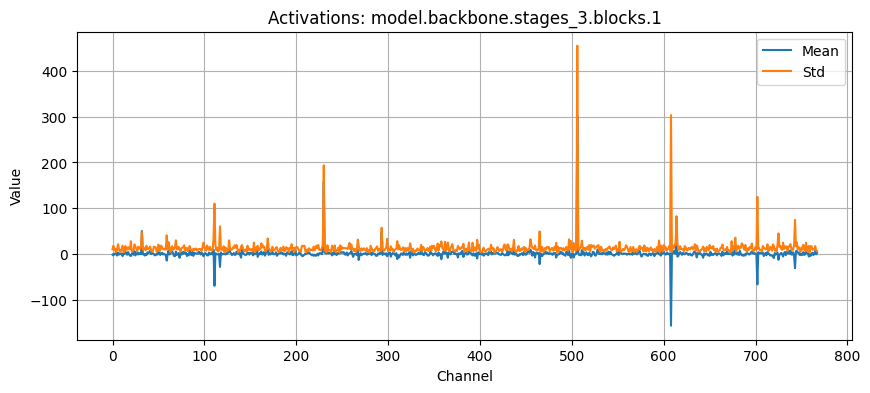

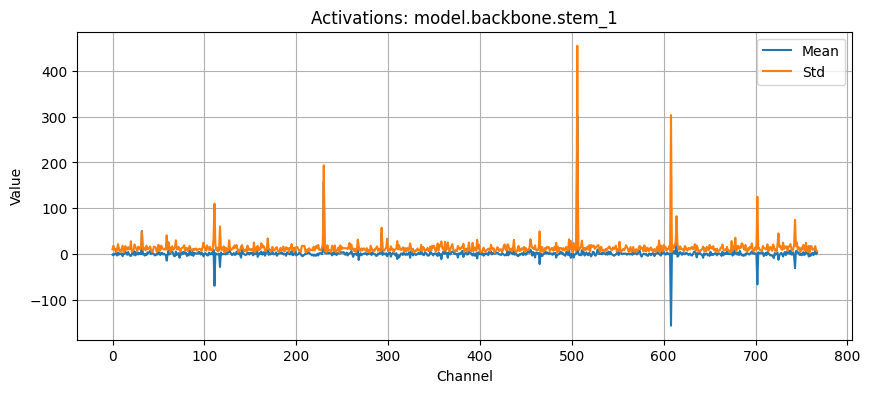

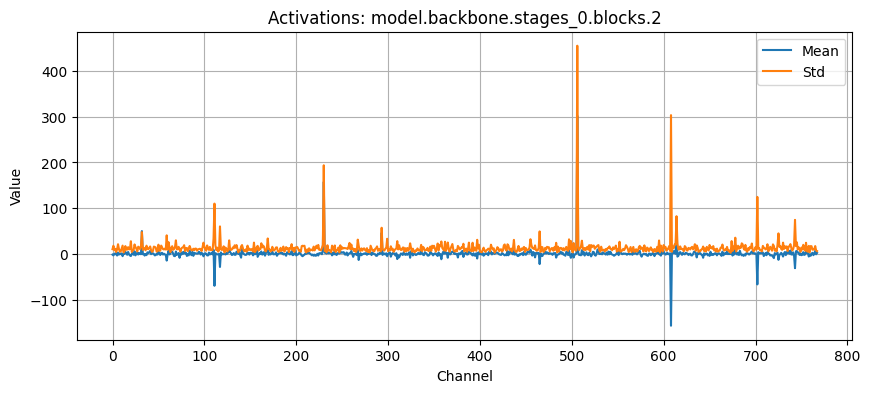

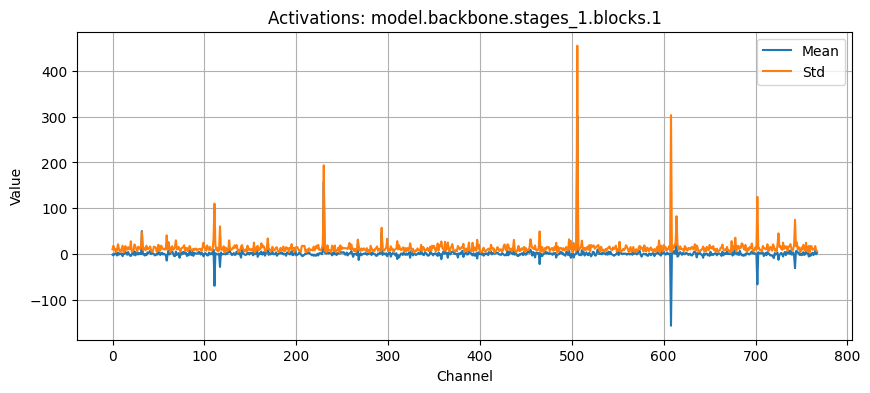

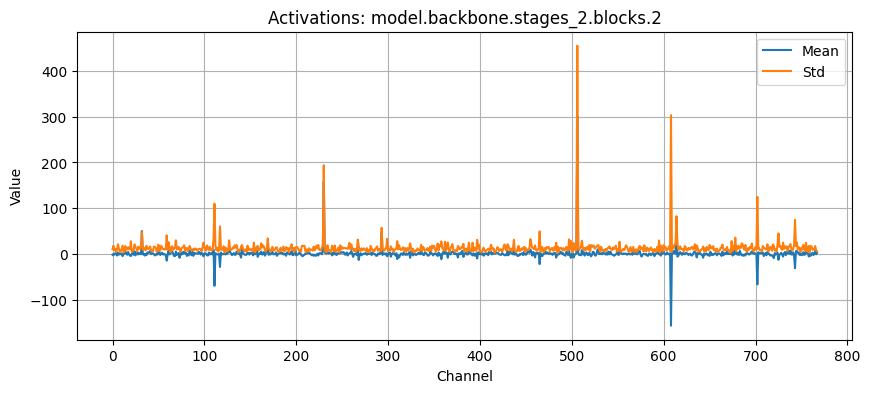

In [46]:
def plot_activation_stats(stats_dict):
    for layer, stats in stats_dict.items():
        plt.figure(figsize=(10, 4))
        plt.plot(stats['mean'], label='Mean')
        plt.plot(stats['std'], label='Std')
        plt.title(f'Activations: {layer}')
        plt.xlabel('Channel')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

B, C, H, W = 1, 5, 1000, 70
random_input = torch.randn(B, C, H, W).to(cfg.device)
output = model(random_input)
plot_activation_stats(activation_stats)


In [41]:
layer_names = list(gradients.keys())
print(layer_names)  # ['layer_4', 'layer_5', ...]

['layer_4', 'layer_3', 'layer_2', 'layer_1', 'layer_0']


In [9]:
gradients

{'layer_4': tensor([[[[ 4.6064e-05,  5.1566e-05,  4.9247e-05,  ...,  4.7361e-05,
             4.4777e-05,  4.9004e-05],
           [ 4.6379e-05,  5.8234e-05,  1.1435e-04,  ...,  9.6879e-05,
             1.1100e-04,  1.0896e-04],
           [-3.5769e-05, -5.7271e-05, -2.6779e-05,  ...,  1.2541e-06,
             1.4233e-04,  1.8031e-04],
           ...,
           [-1.4497e-05, -5.4727e-05, -1.0800e-05,  ..., -2.2554e-05,
            -9.2679e-06,  2.1480e-05],
           [ 4.7573e-05,  3.8803e-05,  5.1663e-05,  ...,  6.4484e-05,
             4.3863e-05,  2.8678e-05],
           [-1.3864e-05, -7.4436e-07, -1.0591e-05,  ...,  2.3263e-05,
             1.8247e-05, -2.4448e-05]],
 
          [[-1.1351e-07,  2.2931e-05,  8.4060e-05,  ...,  7.5530e-05,
             8.0100e-05,  8.8429e-05],
           [-1.5517e-04, -1.8617e-04, -7.9394e-05,  ..., -7.8523e-05,
            -5.4629e-05,  1.1071e-05],
           [-1.0304e-04, -1.2245e-04,  5.5414e-05,  ...,  1.8417e-05,
            -3.3798e-05, -5.

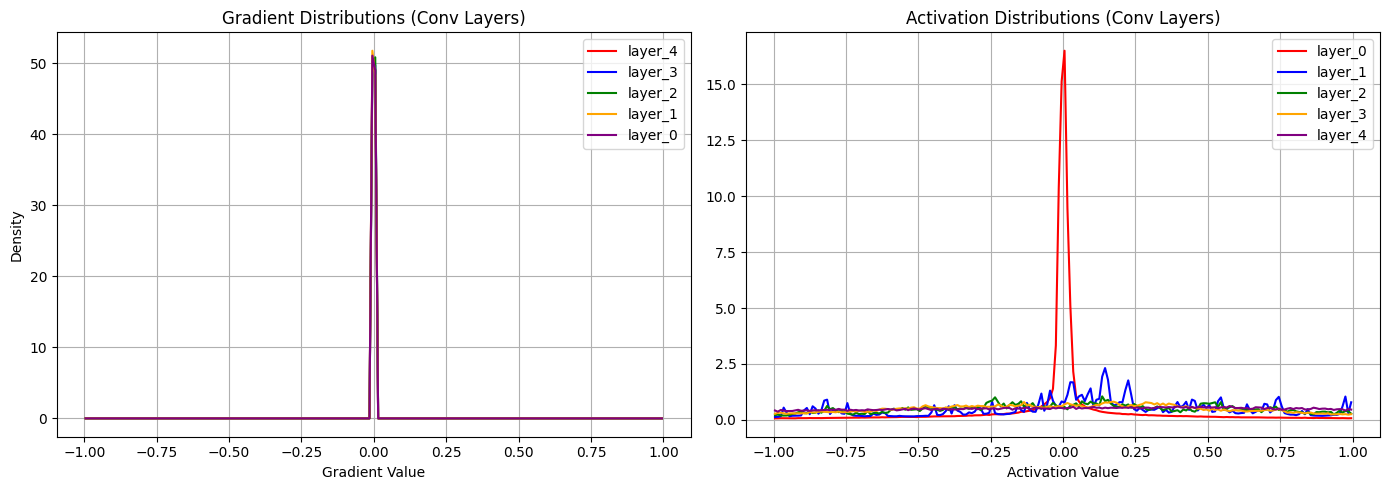

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # No sharey

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
max_layers = 15
layer_count = 0

# Plot Gradients
for name, gradient in gradients.items():
    if 'layer_' in name.lower():
        if layer_count >= max_layers:
            break
        
        flat = gradient.detach().cpu().flatten().numpy()
        hist, bin_edges = np.histogram(flat, bins=200, range=(-1, 1), density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        axes[0].plot(bin_centers, hist, label=name, color=colors[layer_count % len(colors)])
        layer_count += 1

axes[0].set_title('Gradient Distributions (Conv Layers)')
axes[0].set_xlabel('Gradient Value')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True)

# Reset layer count for activations
layer_count = 0

# Plot Activations
for name, activation in activations.items():
    if 'layer_' in name.lower():
        if layer_count >= max_layers:
            break
        
        flat = activation.detach().cpu().flatten().numpy()
        hist, bin_edges = np.histogram(flat, bins=200, range=(-1, 1), density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        axes[1].plot(bin_centers, hist, label=name, color=colors[layer_count % len(colors)])
        layer_count += 1

axes[1].set_title('Activation Distributions (Conv Layers)')
axes[1].set_xlabel('Activation Value')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
ud_array = np.array(ud)

plt.figure(figsize=(20, 4))

for i in range(ud_array.shape[1]):  # loop over conv params
    y = ud_array[:, i]
    # Skip param if contains any NaN or infinite values
    if np.all(np.isfinite(y)):
        plt.plot(y, label=f'conv param {i}')

plt.axhline(-3, color='k', linestyle='--', label='log10(1e-3) threshold')
plt.title("Log-scaled Update Magnitude (UD) over Steps for Conv Params")
plt.xlabel("Training Step")
plt.ylabel("log10(lr * std(grad) / std(param))")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# training code for CPU

import random
import os
import time, glob
import numpy as np
import torch
# Remove or comment out if you don't have it (but typically comes with pytorch)
# import torch.distributed as dist
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset # Use standard DataLoader/Dataset
# from torch.utils.data.distributed import DistributedSampler # Removed
# from torch.cuda.amp import autocast, GradScaler # Removed
from tqdm import tqdm
from _cfg import cfg

def set_seed(seed=cfg.seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # Removed torch.cuda.manual_seed, torch.backends.cudnn settings

data_paths = sorted(glob.glob("./datasetfiles/FlatVel_A/data/*.npy"))
label_paths = sorted(glob.glob("./datasetfiles/FlatVel_A/model/*.npy"))
file_pairs = list(zip(data_paths, label_paths))

def main(cfg):

    # Ensure device is set to 'cpu' in cfg for clarity in this modified version
    cfg.device = 'cpu'

    # ========== Datasets / Dataloaders ==========
    if cfg.local_rank == 0:
        print("="*25)
        print("Loading data..")

    print(f"file_pairs: {cfg.file_pairs[:2]}")
    print(f"Type of first element: {type(cfg.file_pairs[0])}")
    train_ds = CustomDataset(cfg=cfg, file_pairs=file_pairs, mode="train")
    # Replaced DistributedSampler with standard DataLoader and shuffle
    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size= cfg.batch_size,
        num_workers= 0, #4,
        shuffle=True, # Add shuffle for training
    )

    valid_ds = CustomDataset(cfg=cfg, file_pairs=file_pairs, mode="valid")
    # Replaced DistributedSampler with standard DataLoader
    valid_dl = torch.utils.data.DataLoader(
        valid_ds,
        batch_size= cfg.batch_size_val,
        num_workers= 0, #4,
        shuffle=False, # No shuffle for validation
    )

    # ========== Model / Optim ==========
    model = Net(backbone=cfg.backbone)
    # Removed .to(cfg.local_rank) - models are on CPU by default

    if cfg.ema:
        if cfg.local_rank == 0:
            print("Initializing EMA model..")
        # Set device explicitly to 'cpu' for EMA
        ema_model = ModelEMA(
            model,
            decay=cfg.ema_decay,
            device='cpu',
        )
    else:
        ema_model = None

    # Removed DistributedDataParallel wrap - use the base model directly

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # Removed GradScaler - not needed for CPU or non-mixed precision

    # ========== Training ==========
    if cfg.local_rank == 0:
        print("="*25)
        # Adjusted print message
        print("Running on CPU (single process).")
        print("="*25)

    best_loss= 1_000_000
    val_loss= 1_000_000 # Initialize val_loss for logging on epoch 0

    for epoch in range(0, cfg.epochs+1):
        if epoch != 0: # Skip epoch 0 training loop
            tstart= time.time()
            # Removed sampler.set_epoch - not needed for standard DataLoader

            # Train loop
            model.train()
            total_loss = []
            # tqdm for train loop only on rank 0
            train_loop = tqdm(train_dl, disable=cfg.local_rank != 0, desc=f"Epoch {epoch} Training")
            for i, (x, y) in enumerate(train_loop):
                # Removed .to(cfg.local_rank) - data is already on CPU
                # Removed autocast context

                logits = model(x)

                loss = criterion(logits, y)

                # Replaced scaler steps with standard backprop and optimizer step
                loss.backward()
                # Removed scaler.unscale_
                optimizer.step()
                # Removed scaler.update
                optimizer.zero_grad()

                total_loss.append(loss.item())

                if ema_model is not None:
                    ema_model.update(model)

                # Logging within the loop (simplified for single process)
                if cfg.local_rank == 0 and (len(total_loss) >= cfg.logging_steps or i == len(train_dl)-1 or i == 0):
                    current_train_loss_avg = np.mean(total_loss[-cfg.logging_steps:]) # Avg of last logging steps
                    if i == 0: current_train_loss_avg = total_loss[0] # Handle first step log
                    train_loop.set_postfix(train_mae=f"{current_train_loss_avg:.4f}", val_mae=f"{val_loss:.4f}")
                    # Original logging format (can keep if preferred, but tqdm is better)
                    # if (len(total_loss) % cfg.logging_steps == 0 or i == len(train_dl)-1):
                    #    train_loss_avg = np.mean(total_loss)
                    #    print("Epoch {}:     Train MAE: {:.2f}     Val MAE: {:.2f}     Time: {}     Step: {}/{}".format(
                    #        epoch,
                    #        train_loss_avg,
                    #        val_loss,
                    #        format_time(time.time() - tstart),
                    #        i+1,
                    #        len(train_dl), # Fix len(train_dl)+1 -> len(train_dl)
                    #    ))

            # Log average train loss after epoch
            if cfg.local_rank == 0:
                 train_loss_avg_epoch = np.mean(total_loss)
                 print(f"\nEpoch {epoch} Training finished. Avg Train MAE: {train_loss_avg_epoch:.4f}")


        # ========== Valid ==========
        model.eval()
        val_logits = []
        val_targets = []
        # tqdm for validation loop on rank 0
        valid_loop = tqdm(valid_dl, disable=cfg.local_rank != 0, desc=f"Epoch {epoch} Validation")
        with torch.no_grad():
            for x, y in valid_loop:
                # Removed .to(cfg.local_rank) - data is already on CPU

                # Removed autocast context
                if ema_model is not None:
                    # Access the underlying model from EMA wrapper
                    # out = ema_model.ema_model(x) # Or ema_model.model(x) depending on EMA implementation
                    out = ema_model.module(x) # Or ema_model.model(x) depending on EMA implementation
                else:
                    out = model(x)

                val_logits.append(out.cpu())
                val_targets.append(y.cpu())

            val_logits= torch.cat(val_logits, dim=0)
            val_targets= torch.cat(val_targets, dim=0)

            # Calculate loss directly (no all_reduce needed)
            val_loss = criterion(val_logits, val_targets).item()

        # Removed Gather loss (all_reduce) - loss is already the final val_loss

        # ========== Weights / Early stopping ==========
        # Removed stop_train tensor and broadcast - handled directly in single process
        if cfg.local_rank == 0: # This block runs because local_rank is 0
            es= cfg.early_stopping # Ensure es is a local variable
            if val_loss < best_loss:
                print(f"\nNew best: {best_loss:.4f} -> {val_loss:.4f}") # Improved formatting
                print("Saved weights..")
                best_loss = val_loss
                if ema_model is not None:
                    # Save the state dict of the EMA model's actual weights
                    # Assuming ModelEMA stores the EMA model internally, e.g., as .ema_model
                    # Adjust this line based on your ModelEMA implementation
                    torch.save(ema_model.module.state_dict(), f'best_model_{cfg.seed}.pt')
                else:
                    torch.save(model.state_dict(), f'best_model_{cfg.seed}.pt')

                es["streak"] = 0
            else:
                es["streak"] += 1
                print(f"\nValidation loss did not improve. Streak: {es['streak']}/{es['patience']}") # Added log
                if es["streak"] > es["patience"]:
                    print("Ending training (early_stopping).")
                    # Direct return for early stopping
                    return # Exit the main function

        # Added a short delay to allow print statements to flush if needed (less critical for CPU)
        # time.sleep(1) # Optional

    return # End of epochs reached


if __name__ == "__main__":

    # Simplified init for single-process CPU
    # Removed GPU specs check and setup/cleanup calls
    # Removed time.sleep for synchronization

    # Set rank and world_size for the single process
    cfg.local_rank = 0
    cfg.world_size = 1
    cfg.device = 'cpu' # Ensure device is set to CPU

    print(f"Starting single-process CPU test (Rank: {cfg.local_rank}, World size: {cfg.world_size})")

    # Seed (CPU parts kept)
    set_seed(cfg.seed + cfg.local_rank)

    # Run main training/validation loop
    main(cfg)

    print("Training finished.")
    # Removed cleanup call

In [ ]:
model

In [ ]:
###################
###################
###################
%%writefile _train.py

####  for GPU  ####
###################
###################

import os
import time 
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.amp import autocast, GradScaler

import torch.distributed as dist
from torch.utils.data import DistributedSampler
from torch.nn.parallel import DistributedDataParallel

from _cfg import cfg
from _dataset import CustomDataset
from _model import ModelEMA, Net
from _utils import format_time

def set_seed(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def setup(rank, world_size, device=NONE):
    if device is None:
        devide = USE_DEVICE

    if device.upper() == 'CPU':
        dist.init_process_group("gloo", rank=rank, world_size=world_size)
    if device.upper() =='GPU':
        torch.cuda.set_device(rank)
        dist.init_process_group("nccl", rank=rank, world_size=world_size)
    else:
        raise ValueError(f"Unknown device type: {device}")
    return

def cleanup():
    dist.barrier()
    dist.destroy_process_group()
    return

def main(cfg):

    # ========== Datasets / Dataloaders ==========
    if cfg.local_rank == 0:
        print("="*25)
        print("Loading data..")
    train_ds = CustomDataset(cfg=cfg, mode="train")
    sampler= DistributedSampler(
        train_ds, 
        num_replicas=cfg.world_size, 
        rank=cfg.local_rank,
    )
    train_dl = torch.utils.data.DataLoader(
        train_ds, 
        sampler= sampler,
        batch_size= cfg.batch_size, 
        num_workers= 4,
    )
    
    valid_ds = CustomDataset(cfg=cfg, mode="valid")
    sampler= DistributedSampler(
        valid_ds, 
        num_replicas=cfg.world_size, 
        rank=cfg.local_rank,
    )
    valid_dl = torch.utils.data.DataLoader(
        valid_ds, 
        sampler= sampler,
        batch_size= cfg.batch_size_val, 
        num_workers= 4,
    )

    # ========== Model / Optim ==========
    model = Net(backbone=cfg.backbone)
    model= model.to(cfg.local_rank)
    if cfg.ema:
        if cfg.local_rank == 0:
            print("Initializing EMA model..")
        ema_model = ModelEMA(
            model, 
            decay=cfg.ema_decay, 
            device=cfg.local_rank,
        )
    else:
        ema_model = None
    model= DistributedDataParallel(
        model, 
        device_ids=[cfg.local_rank], 
        )
    
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scaler = GradScaler()


    # ========== Training ==========
    if cfg.local_rank == 0:
        print("="*25)
        print("Give me warp {}, Mr. Sulu.".format(cfg.world_size))
        print("="*25)
    
    best_loss= 1_000_000
    val_loss= 1_000_000

    for epoch in range(0, cfg.epochs+1):
        if epoch != 0:
            tstart= time.time()
            train_dl.sampler.set_epoch(epoch)
    
            # Train loop
            model.train()
            total_loss = []
            for i, (x, y) in enumerate(train_dl):
                x = x.to(cfg.local_rank)
                y = y.to(cfg.local_rank)
        
                with autocast(cfg.device.type):
                    logits = model(x)
                    
                loss = criterion(logits, y)
        
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
        
                torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
        
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
    
                total_loss.append(loss.item())
                
                if ema_model is not None:
                    ema_model.update(model)
                    
                if cfg.local_rank == 0 and (len(total_loss) >= cfg.logging_steps or i == 0):
                    train_loss = np.mean(total_loss)
                    total_loss = []
                    print("Epoch {}:     Train MAE: {:.2f}     Val MAE: {:.2f}     Time: {}     Step: {}/{}".format(
                        epoch, 
                        train_loss,
                        val_loss,
                        format_time(time.time() - tstart),
                        i+1, 
                        len(train_dl)+1, 
                    ))
    
        # ========== Valid ==========
        model.eval()
        val_logits = []
        val_targets = []
        with torch.no_grad():
            for x, y in tqdm(valid_dl, disable=cfg.local_rank != 0):
                x = x.to(cfg.local_rank)
                y = y.to(cfg.local_rank)
    
                with autocast(cfg.device.type):
                    if ema_model is not None:
                        out = ema_model.module(x)
                    else:
                        out = model(x)

                val_logits.append(out.cpu())
                val_targets.append(y.cpu())

            val_logits= torch.cat(val_logits, dim=0)
            val_targets= torch.cat(val_targets, dim=0)
                
            loss = criterion(val_logits, val_targets).item()

        # Gather loss
        v = torch.tensor([loss], device=cfg.local_rank)
        torch.distributed.all_reduce(v, op=dist.ReduceOp.SUM)
        val_loss = (v[0] / cfg.world_size).item()
    
        # ========== Weights / Early stopping ==========
        stop_train = torch.tensor([0], device=cfg.local_rank)
        if cfg.local_rank == 0:
            es= cfg.early_stopping
            if val_loss < best_loss:
                print("New best: {:.2f} -> {:.2f}".format(best_loss, val_loss))
                print("Saved weights..")
                best_loss = val_loss
                if ema_model is not None:
                    torch.save(ema_model.module.state_dict(), f'best_model_{cfg.seed}.pt')
                else:
                    torch.save(model.state_dict(), f'best_model_{cfg.seed}.pt')
        
                es["streak"] = 0
            else:
                es= cfg.early_stopping
                es["streak"] += 1
                if es["streak"] > es["patience"]:
                    print("Ending training (early_stopping).")
                    stop_train = torch.tensor([1], device=cfg.local_rank)
        
        # Exits training on all ranks
        dist.broadcast(stop_train, src=0)
        if stop_train.item() == 1:
            return

    return
    


if __name__ == "__main__":

    # GPU Specs
    rank = int(os.environ["RANK"])
    world_size = int(os.environ["WORLD_SIZE"])
    _, total = torch.cuda.mem_get_info(device=rank)

    # Init
    setup(rank, world_size)
    time.sleep(rank)
    print(f"Rank: {rank}, World size: {world_size}, GPU memory: {total / 1024**3:.2f}GB", flush=True)
    time.sleep(world_size - rank)

    # Seed
    set_seed(cfg.seed+rank)

    # Run
    cfg.local_rank= rank
    cfg.world_size= world_size
    main(cfg)
    cleanup()

In [ ]:
if RUN_TRAIN:
    print("Starting training..")
    !set OMP_NUM_THREADS=1 && torchrun --nproc_per_node=1 _train.py